## Try different Boosting models to get better predictions

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from regression_models import dosomething
from preprocessing import mean_and_std

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
outliers_df = pd.read_csv("geocoded.csv")
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353 entries, 0 to 2352
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    2353 non-null   int64  
 1   bed             2353 non-null   float64
 2   bath            2353 non-null   float64
 3   acre_lot        2353 non-null   float64
 4   zip_code        2353 non-null   float64
 5   house_size      2353 non-null   float64
 6   prev_sold_date  2353 non-null   object 
 7   price           2353 non-null   float64
 8   prev_sold_year  2353 non-null   int64  
 9   zip_code_str    2353 non-null   int64  
 10  latitude        2353 non-null   float64
 11  longitude       2353 non-null   float64
 12  county          2353 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 239.1+ KB


In [4]:
outliers_df.head()

,Unnamed: 0.1,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude,county
0,0,3.0,3.0,1.14,18013.0,1865.0,2017-08-01,279900.0,2017,18013,40.848762,-75.177293,19
1,1,3.0,1.0,0.09,18013.0,904.0,2019-03-26,135900.0,2019,18013,40.848762,-75.177293,19
2,2,4.0,3.0,2.67,18013.0,2607.0,2019-07-10,575000.0,2019,18013,40.848762,-75.177293,19
3,3,3.0,2.0,1.85,18013.0,2567.0,2019-05-21,549900.0,2019,18013,40.848762,-75.177293,19
4,4,3.0,2.0,0.09,18013.0,1377.0,2022-03-04,190000.0,2022,18013,40.848762,-75.177293,19


#### Create an object to pass to the function that will normalize the data

In [5]:
params = {
    "data":outliers_df,
    "features_a":["prev_sold_year","latitude","longitude","zip_code"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
normalize_df = mean_and_std(params)
#normalize_df = outliers_df
normalize_df.tail()

,bed,bath,acre_lot,house_size,price,prev_sold_year,latitude,longitude,zip_code
2348,-0.114690,0.899517,3.906344,0.465563,-0.062128,2020,41.724706,-75.535516,18470.0
2349,-0.114690,-0.228114,6.641879,-0.690409,-1.278760,2021,41.724706,-75.535516,18470.0
2350,-1.263051,-0.228114,-0.196959,0.515690,-1.170057,2022,41.664210,-75.492886,18421.0
2351,-1.263051,-1.355745,-0.014590,-1.724860,-1.113615,2021,41.583410,-75.396687,18472.0
2352,-0.114690,-0.228114,0.046199,-0.655472,-1.046721,2020,41.989756,-75.722751,18821.0


#### Create a variable for the correlation of the normalized data

In [6]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot          0.077694
bed               0.193403
bath              0.571221
house_size        0.566448
prev_sold_year   -0.129353
price             1.000000
Name: price, dtype: float64

#### Display a Heatmap with the correlated data

Text(0.5, 1.0, 'Correlation Between Variables')

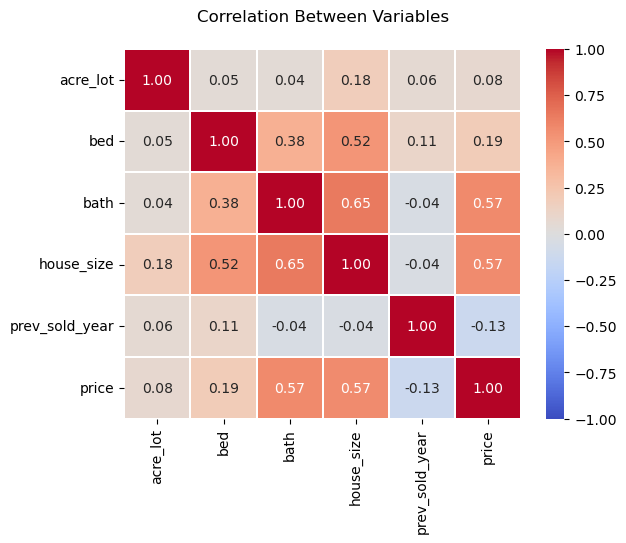

In [7]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

#### Create a variable to hold the features that correlate with the price feature between 0.20 and 0.80

In [8]:
'''
'''
savefeatures = ["latitude","longitude"]
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.03:
        savefeatures.append(feature)

print(savefeatures)

['latitude', 'longitude', 'acre_lot', 'bed', 'bath', 'house_size', 'prev_sold_year']


#### Create common variables to store frequently used values.

In [9]:
#features = ["latitude","longitude","bed","bath","house_size"]
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [10]:
X = normalize_df[savefeatures]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [11]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [12]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

#### Ada Boosting

In [13]:
adaboost = dosomething("Ada Boost","Ada Boost", normalize_df, features, "price")
results_dict_append(adaboost["results"])
adaboost_predict = adaboost["predictions"]

The selected features are: ['latitude', 'longitude', 'acre_lot', 'bed', 'bath', 'house_size', 'prev_sold_year']
Ada Boost EVS = 0.309311667
Ada Boost MSE = 0.851915
Ada Boost MAE = 0.647211
Ada Boost R2 = 0.197421
Ada Boost Fit Time = 0.06627044677734376


#### Gradient Boosting

In [14]:
gbr = dosomething("Gradient Boosting","Gradient Boosting", normalize_df, features, "price")
results_dict_append(gbr["results"])
gbr_predict = gbr["predictions"]

The selected features are: ['latitude', 'longitude', 'acre_lot', 'bed', 'bath', 'house_size', 'prev_sold_year']
Gradient Boosting EVS = 0.699047770
Gradient Boosting MSE = 0.320033
Gradient Boosting MAE = 0.354180
Gradient Boosting R2 = 0.698500
Gradient Boosting Fit Time = 0.1663498878479004


#### Hist Gradient Boosting

In [15]:
histgbr = dosomething("Hist Gradient Boosting","Hist Gradient Boosting", normalize_df, features, "price")
results_dict_append(histgbr["results"])
histgbr_predict = histgbr["predictions"]

The selected features are: ['latitude', 'longitude', 'acre_lot', 'bed', 'bath', 'house_size', 'prev_sold_year']
Hist Gradient Boosting EVS = 0.637113535
Hist Gradient Boosting MSE = 0.385532
Hist Gradient Boosting MAE = 0.377455
Hist Gradient Boosting R2 = 0.636794
Hist Gradient Boosting Fit Time = 0.5150489330291748


#### Random Forest

In [16]:
rf = dosomething("Random Forest","Random Forest", normalize_df, features, "price")
results_dict_append(rf["results"])
rf_predict = rf["predictions"]

The selected features are: ['latitude', 'longitude', 'acre_lot', 'bed', 'bath', 'house_size', 'prev_sold_year']
Random Forest EVS = 0.631574270
Random Forest MSE = 0.391075
Random Forest MAE = 0.376502
Random Forest R2 = 0.631573
Random Forest Fit Time = 1.018368673324585


#### Graphing the results works best when the data is provided in a DataFrame.

In [17]:
adaboost_predict_df = pd.DataFrame(adaboost_predict).reset_index()
adaboost_predict_df.rename(columns={0: "prediction"},inplace=True)

gbr_predict_df = pd.DataFrame(gbr_predict).reset_index()
gbr_predict_df.rename(columns={0: "prediction"},inplace=True)

rf_predict_df = pd.DataFrame(rf_predict).reset_index()
rf_predict_df.rename(columns={0: "prediction"},inplace=True)

histgbr_predict_df = pd.DataFrame(histgbr_predict).reset_index()
histgbr_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

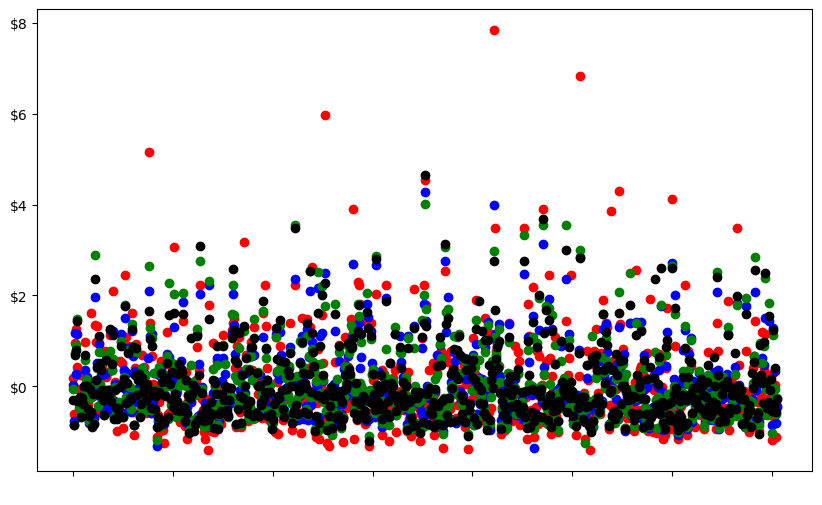

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(gbr_predict_df.index,gbr_predict_df["prediction"], color="blue")
plt.scatter(histgbr_predict_df.index,histgbr_predict_df["prediction"], color="green")
#plt.scatter(adaboost_predict_df.index,adaboost_predict_df["prediction"], color="black")
plt.scatter(rf_predict_df.index,rf_predict_df["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [19]:
results_dict

{'model': ['Ada Boost',
  'Gradient Boosting',
  'Hist Gradient Boosting',
  'Random Forest'],
 'explained variance score': ['0.309311667',
  '0.699047770',
  '0.637113535',
  '0.631574270'],
 'mae score': ['0.647211', '0.354180', '0.377455', '0.376502'],
 'mse score': ['0.851915', '0.320033', '0.385532', '0.391075'],
 'r2 score': ['0.197421', '0.698500', '0.636794', '0.631573'],
 'mean fit time': [0.06627044677734376,
  0.1663498878479004,
  0.5150489330291748,
  1.018368673324585]}

In [20]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Ada Boost,0.309311667,0.647211,0.851915,0.197421,0.066270
Gradient Boosting,0.699047770,0.354180,0.320033,0.698500,0.166350
Hist Gradient Boosting,0.637113535,0.377455,0.385532,0.636794,0.515049
Random Forest,0.631574270,0.376502,0.391075,0.631573,1.018369
